# Wall velocity LTE

In [1]:
import numpy as np
from numpy import linalg as la
from scipy import integrate
from scipy import optimize
from scipy import interpolate
import scipy as sp
from matplotlib import pyplot as plt
import plotter as pl
from helperFunctions import derivative, alpha_p, cs_sq, dYdtau, dvTdxi, r_func, μ, w

Abs = np.abs
Log = np.log
Log10 = np.log10
Pi = np.pi
Sqrt = np.sqrt
Exp = np.exp
Cos = np.cos
Sin = np.sin
Sech = lambda x: 1/np.cosh(x)
Tanh = np.tanh
ArcSin = np.arcsin
ArcTanh = np.arctanh
Arg = np.angle
BesselK = sp.special.kv
Zeta = sp.special.zeta
HeavisideTheta = lambda x: np.heaviside(x, 0)


def Plot(fun, xminmax, n=100,xfun=np.linspace, xlog=False, ylog=False):
    xlist = xfun(xminmax[0], xminmax[1], n)
    ylist = [fun(x) for x in xlist]
    plt.plot(xlist, ylist)
    if xlog:
        plt.xscale('log')
    if ylog:
        plt.yscale('log')

## Prepare

In [2]:
import SM_model as m

In [3]:
mod = m.SM(1,0.007285228,636.8644639563023)

Model inialized.
g2 = 1
λ = 0.007285228
μh = 25.236173718618723


In [4]:
mod.findTc()
mod.findTn()

Finding Tc...
Critical temperature found! Tc = 56.636213599704206
v_c/Tc = 2.805112061801922
Finding Tn...
Tunneling at T = 56.6162135997042
S3/T = 1776610.821118072
Tunneling at T = 56.5962135997042
S3/T = 451853.48759337695
Tunneling at T = 56.576213599704204
S3/T = 203892.6206760976
Tunneling at T = 56.5562135997042
S3/T = 116379.02610579527
Tunneling at T = 56.536213599704205
S3/T = 75553.78881274353
Tunneling at T = 56.5162135997042
S3/T = 53207.225980410876
Tunneling at T = 56.496213599704205
S3/T = 39631.40596042085
Tunneling at T = 56.4762135997042
S3/T = 30754.56578884889
Tunneling at T = 56.456213599704206
S3/T = 24623.812731046
Tunneling at T = 56.4362135997042
S3/T = 20206.5170962416
Tunneling at T = 56.4162135997042
S3/T = 16914.527920606317
Tunneling at T = 56.396213599704204
S3/T = 14392.707450128244
Tunneling at T = 56.3762135997042
S3/T = 12416.149901957511
Tunneling at T = 56.356213599704205
S3/T = 10836.688219983376
Tunneling at T = 56.3362135997042
S3/T = 9553.51473

In [5]:
Vtot=mod.Vtot
hv = np.array([0.0])
lv = np.array([mod.Tnvev])
Tnuc = mod.Tn

In [154]:
Vtot(hv, 0)

-5706.668915903859

In [157]:
optimize.fmin(Vtot, lv, args=(0,))

Optimization terminated successfully.
         Current function value: -9466427.988958
         Iterations: 21
         Function evaluations: 42


array([246.22000216])

In [158]:
-5706.668915903859 - (-9466427.988958)

9460721.320042096

## Quantities

In [6]:
def derivative(f, x, eps=1e-5, order=1):
    """Calculate the derivative of a function.
    Using Ridders algorithm.
    Calculate up to order x**4.
    Only compute 1st or 2nd order derivative."""
    assert (
        order == 1 or order == 2
    ), "Calculate derivative up to an order, must be 1 or 2."
    δx = x * eps
    if order == 1:
        return (f(x - 2 * δx) - 8 * f(x - δx) + 8 * f(x + δx) - f(x + 2 * δx)) / (
            12 * δx
        )
    if order == 2:
        return (f(x - 2 * δx) - f(x - δx) - f(x + δx) + f(x + 2 * δx)) / (3 * δx**2)

In [7]:
def w(V, vev, T):
    v = optimize.fmin(V, vev, args=(T,), disp=0)
    p = lambda T: - Vtot(v, T)
    return T * derivative(p, T)

In [8]:
def a(V, vev, T):
    return 0.75 * w(V, vev, T)/T**4

In [148]:
a(Vtot, hv, Tnuc)

35.09342833881541

In [149]:
Pi**2 * 106.75/30

35.11934232720964

In [150]:
Pi**2 * 83.25/30

27.38815221302297

In [152]:
a(Vtot, lv, 53)

33.285112005900665

In [9]:
def e(V, vev, T):
    v = optimize.fmin(V, vev, args=(T,), disp=0)
    p = lambda T: - Vtot(v, T)
    return w(V, vev, T) - p(T)

In [13]:
def σ(V, vev, T):
    v = optimize.fmin(V, vev, args=(T,), disp=0)
    p = lambda T: - Vtot(v, T)
    return derivative(p, T)

In [14]:
def ε(V, vev, T):
    v = optimize.fmin(V, vev, args=(T,), disp=0)
    p = lambda T: - Vtot(v, T)
    return 0.25 * (e(V, vev, T) - 3 * p(T))

In [15]:
def alpha_p(V, hv, lv, Tp, Tm):
    εp = ε(V, hv, Tp)
    εm = ε(V, lv, Tm)
    return (εp-εm)/(a(V, hv, Tp) * Tp**4)

In [16]:
def r(V, hv, lv, Tp, Tm):
    ap = a(V, hv, Tp)
    am = a(V, lv, Tm)
    return ap * Tp**4/(am * Tm**4)

In [37]:
def cs_sq(Vtot, vev, T):
    v = optimize.fmin(Vtot, vev, args=(T,), disp=0)
    V = lambda T: Vtot(v, T)
    y = derivative(V, T)
    y = y/T
    y = y/derivative(V, T, order=2)
    return y

## Solving the boundary condition

In [17]:
def match(vp, vm, Tp, Tm, hv, lv, V):
    vpvm = 1 - (1 -3 * alpha_p(V, hv, lv, Tp, Tm)) * r(V, hv, lv, Tp, Tm)
    vpvm = vpvm/(3 - 3*(1 + alpha_p(V, hv, lv, Tp, Tm)) * r(V, hv, lv, Tp, Tm))

    ratio = 3 + (1 - 3 *alpha_p(V, hv, lv, Tp, Tm) ) * r(V, hv, lv, Tp, Tm)
    ratio = ratio/(1 + 3 * (1 + alpha_p(V, hv, lv, Tp, Tm)) * r(V, hv, lv, Tp, Tm))

    return np.array([vp*vm - vpvm, vp/vm - ratio])

In [19]:
vw = 0.9
vm, Tm = optimize.fsolve(lambda x: match(vw, x[0], Tnuc, x[1], hv, lv, Vtot), [0.7, Tnuc+1])

In [21]:
alp = alpha_p(Vtot, hv, lv, Tnuc, Tm)

In [26]:
(0.5* vm + 1/(6*vm) + np.sqrt((0.5* vm + 1/(6*vm))**2 + alp**2 + 2*alp/3 - 1/3))/(1+alp)

0.8999999997433227

In [159]:
vw = 0.5
Tm = 53.0
vp, Tp = optimize.fsolve(lambda x: match(x[0], vw, x[1], Tm, hv, lv, Vtot), [0.2, Tnuc+1])

In [160]:
vp

0.4356517817504069

In [161]:
Tp

55.19349796094481

In [126]:
def μ(xi, v):
    return (xi - v)/(1 -xi * v)

In [127]:
def dYdtau(tau, y, *args):
    v = y[0]
    T = y[1]
    xi = y[2]

    V = args[0]
    vev = args[1]

    dvdtau = 2 * v * cs_sq(Vtot, vev, T) * (1 - v**2) * (1- xi * v)
    dxidtau = xi * ((xi - v)**2 - cs_sq(Vtot, vev, T) * (1-xi*v)**2)
    dTdtau = T * μ(xi, v) * dvdtau /(1-v**2)

    return np.array([dvdtau, dTdtau, dxidtau])

In [162]:
ini = np.array([μ(vw, vp), Tp, vw])

In [163]:
ini

array([ 0.08226841, 55.19349796,  0.5       ])

In [164]:
sol=integrate.solve_ivp(dYdtau, (10,0.01), ini ,t_eval=np.linspace(10,0.01,10000),method='DOP853', args=(Vtot, hv))

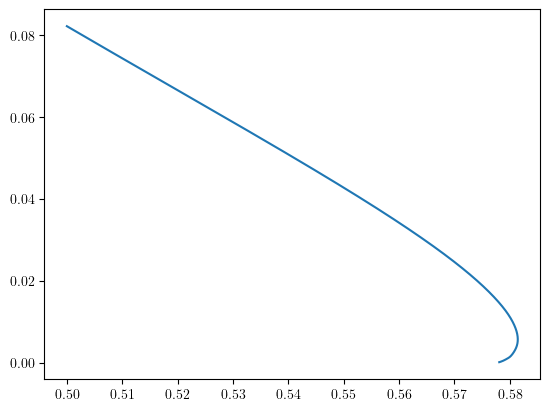

In [165]:
plt.plot(sol.y[2], sol.y[0])

In [166]:
xi_max = sol.y[2].max()
xi_max_index = sol.y[2].argmax()

In [135]:
xi_max_index

9999

In [167]:
v_prof = interpolate.interp1d(sol.y[2][0:xi_max_index+1], sol.y[0][0:xi_max_index+1],kind='linear')
T_prof = interpolate.interp1d(sol.y[2][0:xi_max_index+1], sol.y[1][0:xi_max_index+1],kind='linear')

In [136]:
T_prof(xi_max)

array(53.15038946)

In [171]:
ind = np.argmax(sol.y[2][0:xi_max_index+1] > 0.59)

In [108]:
ind

1098

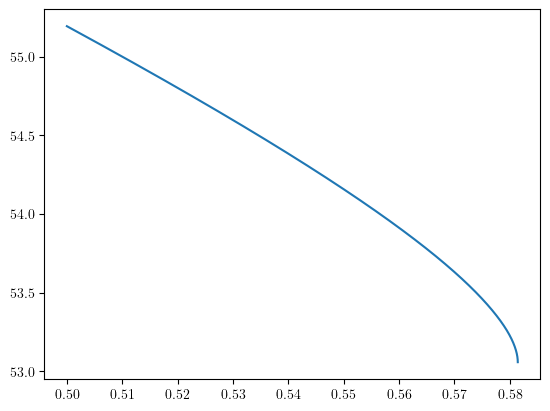

In [169]:
plt.plot(sol.y[2][0:xi_max_index+1], sol.y[1][0:xi_max_index+1])

In [102]:
optimize.brentq(lambda xi: μ(xi, v_prof(xi)) * xi - cs_sq(Vtot, hv, T_prof(xi)), sol.y[2][0], xi_max)

0.594424370349433

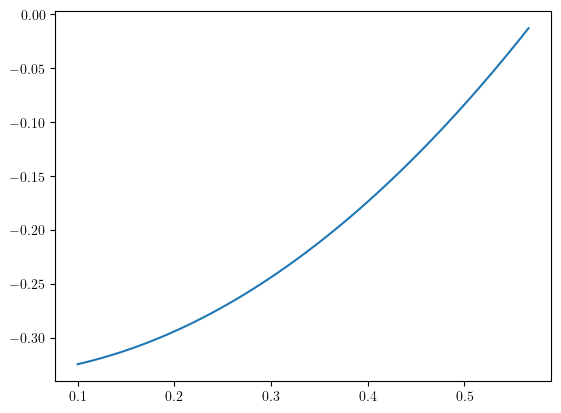

In [137]:
Plot(lambda xi: μ(xi, v_prof(xi)) * xi - cs_sq(Vtot, hv, T_prof(xi)), (sol.y[2][0], xi_max))

In [113]:
def find_Tsh(Tm, vw):
    vp, Tp = optimize.fsolve(lambda x: match(x[0], vw, x[1], Tm, hv, lv, Vtot), [0.2, Tnuc+1])
    ini = np.array([μ(vw, vp), Tp, vw])
    sol=integrate.solve_ivp(dYdtau, (10,0.01), ini ,t_eval=np.linspace(10,0.01,10000),method='DOP853', args=(Vtot, hv))
    xi_max = sol.y[2].max()
    xi_max_index = sol.y[2].argmax()
    v_prof = interpolate.interp1d(sol.y[2][0:xi_max_index+1], sol.y[0][0:xi_max_index+1],kind='linear')
    T_prof = interpolate.interp1d(sol.y[2][0:xi_max_index+1], sol.y[1][0:xi_max_index+1],kind='linear')

    xsh = optimize.brentq(lambda xi: μ(xi, v_prof(xi)) * xi - cs_sq(Vtot, hv, T_prof(xi)), sol.y[2][0], xi_max)
    return T_prof(xsh)

In [138]:
find_Tsh(53, 0.5)

array(53.1655056)

In [114]:
find_Tsh(53, 0.55)

array(54.36188419)

In [144]:
Tmlist = np.linspace(50,53, 10)
Tshlist = np.ones((10,))
for i in range(10):
    Tm = Tmlist[i]
    Tshlist[i] = find_Tsh(Tm, 0.5)


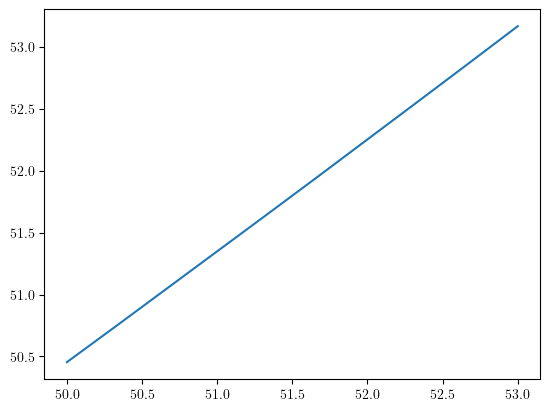

In [145]:
plt.plot(Tmlist, Tshlist)

In [118]:
optimize.newton(lambda Tm: find_Tsh(Tm, 0.55)-Tnuc, 52)

51.82238765059631

In [142]:
vwlist = np.linspace(0.45, 0.55, 3)
slist = np.ones((3,))

In [147]:
for i in range(3):
    vw = vwlist[i]
    print('vw = ' + str(vw))
    try:
        Tm = optimize.newton(lambda Tm: find_Tsh(Tm, vw)-Tnuc, 52)
    except:
        Tm = optimize.brentq(lambda Tm: find_Tsh(Tm, vw)-Tnuc, 50,55)

    vp, Tp = optimize.fsolve(lambda x: match(x[0], vw, x[1], Tm, hv, lv, Vtot), [0.2, Tnuc+1])

    vm = vw

    lv_new = optimize.fmin(Vtot, lv, args=(Tm,), disp=0)
    diff = - Tp/Sqrt(1-vp**2) + Tm/Sqrt(1-vm**2)
    print(diff)
    slist[i] = diff

vw = 0.45
-0.12213745111245089
vw = 0.5
-0.10927464465925851
vw = 0.55
-0.13117461319065882
